# Revisiting the DLAs of Fig19 in our submitted paper

In [14]:
%matplotlib notebook

In [23]:
# imports
from matplotlib import pyplot as plt

from astropy import units as u

from dla_cnn.io import load_ml_dr12, load_garnett16

from specdb.specdb import IgmSpec

In [2]:
igmsp = IgmSpec()

Database is igmspec
Created on 2017-Jan-31


In [3]:
## Systems
junk_plates = [6466, 5059, 4072, 3969]
junk_fibers = [740, 906, 162, 788]
wvoffs = [200., 200., 200., 200.]
zabs = [2.8159, 2.4272, 3.3509, 2.9467]

## 6466, 740: 

    |  6466 |   740 | 3.2766 | 2.8738 |  21.969 |  0.605782117821 | Bad data; SHOW


### Garnett writes:

    - For the missing data example, we ignore the part of the spectrum
    that's missing (those pixels are masked by the pipeline). What the
    algorithm "sees" is:

    https://i.imgur.com/m6Z3C5m.png

    The red curve is the prior mean of the DLA GP model with the MAP DLA
    parameters applied. The absorption feature just below 4000 A is what
    is causing the high probability and what we report. There seems to be
    something there.

### JXP notes:
    z=2.87 is not 4000A
    I am guessing this was fixed in their new catalog
    Rechecking the old one

In [4]:
g16_abs = load_garnett16(orig=True)
g16_dlas = g16_abs[g16_abs['log.NHI'] >= 20.3]

In [5]:
g16_dlas[0:5]

THINGID,SDSS,Plate,MJD,Fiber,RAdeg,DEdeg,z_QSO,SNRSpec,b_z_DLA,B_z_DLA,log.pnDLA,log.pDLA,log.pDnDLA,log.pDDLA,pnDLAD,pDLAD,z_DLA,log.NHI,flg_BAL,SNR
,,,d,,deg,deg,,,,,,,,,,,,[cm-2],,
int64,str18,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
21077479,000005.10-104850.0,7167,56604,290,0.0212802,-10.8139164,2.7147,0.9489,2.1342,2.7044,-0.05841,-2.8693,-1392.31,-1372.63,4.70432e-08,1.0,2.4839,20.9663,0,0.9489
198728627,000010.89+094235.0,6182,56190,338,0.0453844,9.7097468,2.7771,5.7421,2.1869,2.7673,-0.06304,-2.79534,-680.816,-528.647,1.26021e-65,1.0,2.3424,21.1469,0,5.7421
219876249,000012.43+121018.1,6151,56265,78,0.0518013,12.1717141,2.3246,1.7046,1.9315,2.3142,-0.03209,-3.45512,-678.571,-678.388,0.962295,0.0377053,1.9372,20.3854,0,1.7046
311558563,000013.20+225735.8,6879,56539,580,0.0550157,22.9599543,2.4592,1.7662,1.9729,2.4493,-0.0427,-3.17478,-988.541,-989.223,0.978419,0.021581,2.0051,20.5876,0,1.7662
113606237,000015.17+004833.2,4216,55477,718,0.0632145,0.8092483,3.0278,21.664,2.3984,3.0179,-0.08186,-2.54337,-633.65,-497.32,7.27e-59,1.0,2.5237,20.7976,0,21.664


In [6]:
mt = (g16_dlas['Plate'] == 6466) & (g16_dlas['Fiber'] == 740)

In [7]:
g16_dlas[mt]['z_DLA']

2.8738


In [8]:
(1+g16_dlas[mt]['z_DLA'])*1215.67

4709.262446


#### My point remains

## 5059, 906
    |  5059 |   906 |  2.556 | 2.4272 | 22.0779 | 0.0280890265759 | SHOW; junk; maybe weak CIV

## 3969, 788

### Garnett writes
        - For the noisy example, I think there may indeed be a DLA. It's a bit
    hard to see though due to all the noise. Here's the data:

    https://i.imgur.com/rmpOJkJ.png

    Hard to see anything. If you change the aspect ratio a bit, however,
    you start to see something in the noise. Try this:

    https://i.imgur.com/s4wWbPA.png

    If you don't see anything, try standing back 10 feet or tilting your
    monitor away from you. There is an unmistakable large
    absorption-shaped feature centered at 4800 A. Applying a 11-pixel
    boxcar to this really low-SNR spectrum, we get the following:

    https://i.imgur.com/UPH7ktb.png

    which matches the MAP profile pretty well, with some plausible
    corresponding absorption at Lyman beta at ~4100 A. I'd be willing
    to bet there's something there.

In [9]:
mt4 = (g16_dlas['Plate'] == 3969) & (g16_dlas['Fiber'] == 788)
g16_dlas[mt4]

THINGID,SDSS,Plate,MJD,Fiber,RAdeg,DEdeg,z_QSO,SNRSpec,b_z_DLA,B_z_DLA,log.pnDLA,log.pDLA,log.pDnDLA,log.pDDLA,pnDLAD,pDLAD,z_DLA,log.NHI,flg_BAL,SNR
,,,d,,deg,deg,,,,,,,,,,,,[cm-2],,
int64,str18,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
424829313,123800.15+383847.3,3969,55307,788,189.5006462,38.6464919,3.222,1.5219,2.5623,3.2117,-0.09467,-2.40432,-2153.68,-2136.43,3.24607e-07,1.0,2.9467,21.7833,0,1.5219


### The probability given by MAP is 1.0 or 3.24e-7 of no DLA
    That seems quite a bit stronger than:  "I'd be willing to bet there's something there"

### Re-examining
    This time around, I note strong absorption at CII
    Probably not real, but worth noting

In [12]:
# Grab spectrum
spec, meta = igmsp.get_sdss(3969, 788)

/home/xavier/local/Python/linetools/linetools/spectra/xspectrum1d.py:249: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Grabbing data for J123800.1551+383847.3709
Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra


In [13]:
meta

RA_GROUP,DEC_GROUP,THING_ID,PLATE,MJD,FIBERID,Z_VI,Z_PIPE,ERR_ZPIPE,ZWARNING,Z_PCA,ERR_ZPCA,PCA_QUAL,Z_CIV,Z_CIII,Z_MGII,SDSS_MORPHO,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,NSPEC_BOSS,PLATE_DUPLICATE [32],MJD_DUPLICATE [32],FIBERID_DUPLICATE [32],SDSS_DR7,PLATE_DR7,MJD_DR7,FIBERID_DR7,UNIFORM,ALPHA_NU,SNR_SPEC,SNR_DUPLICATE [32],SNR_1700,SNR_3000,SNR_5150,FWHM_CIV,BHWHM_CIV,RHWHM_CIV,AMP_CIV,REWE_CIV,ERR_REWE_CIV,FWHM_CIII,BHWHM_CIII,RHWHM_CIII,AMP_CIII,REWE_CIII,ERR_REWE_CIII,FWHM_MGII,BHWHM_MGII,RHWHM_MGII,AMP_MGII,REWE_MGII,ERR_REWE_MGII,BAL_FLAG_VI,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,CHI2TROUGH,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,REW_SIIV,REW_CIV,REW_ALIII,RUN_NUMBER,PHOTO_MJD,COL_NUMBER,FIELD_NUMBER,PSFFLUX [5],IVAR_PSFFLUX [5],PSFMAG [5],ERR_PSFMAG [5],TARGET_FLUX [5],MI,DGMI,EXTINCTION [5],EXTINCTION_RECAL [5],HI_GAL,VAR_MATCHED,VAR_CHI2,VAR_A,VAR_GAMMA,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,N_DETECTION_XMM,FLUX02_12KEV_SGL,ERR_FLUX02_12KEV_SGL,FLUX02_2KEV,ERR_FLUX02_2KEV,FLUX2_12KEV,ERR_FLUX2_12KEV,FLUX02_12KEV,ERR_FLUX02_12KEV,LUM02_2KEV_SGL,LUM05_2KEV,LUM2_12KEV,LUM02_2KEV,LUMX2_10_UPPER,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,R,zem_GROUP,sig_zem,IGM_ID,NPIX,WV_MIN,WV_MAX,GROUP_ID,EPOCH,flag_co,SDSS_NAME,RERUN_NUMBER,OBJ_ID,CC_FLAGS,PH_FLAG,DATE-OBS,flag_zem,STYPE,SPEC_FILE,CAT,INSTR,DISPERSER,TELESCOPE,GROUP
float64,float64,int32,int32,int32,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,int64,int64,int64,int64,int32,int32,int32,int32,int32,int32,int32,int32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,float64,float64,int16,int32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,int16,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,int64,str18,str3,str19,str4,str4,str10,str9,str3,str28,str5,str4,str4,str10,str9
189.5006,38.6465,424829313,3969,55307,788,3.222,3.20869874954,0.00140039413236,4,3.2525816259,0.00449720478815,0.327634787141,3.2260329457,3.20296245391,-1.0,0,2199023779840,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,0,-1,-1,-1,0,0.568309169097,1.5218841826,-1.0 .. -1.0,1.89272336924,-1.0,-1.0,4351.71295327,1297.85983943,3053.85311384,1.04278707258,24.4814954176,0.974999759188,7347.95366015,2845.70332861,4502.25033155,0.736226838183,41.6654015358,34.9980203314,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,4504,53080,6,195,-0.5858066082 .. 2.55975818634,13.3696336746 .. 1.18081784248,26.2460308075 .. 21.3984012604,0.457330346107 .. 0.337915837765,-1.0 .. -1.0,-24.9019910956,0.458305597305,0.0600606240332 .. 0.017231747508,0.170924 .. 0.0509264,21.9577509109,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,-0.179359197617,48.800657013,-0.116526156664,2

### Zoom-in at Lya
    Lots of residual looking flux there..

<IPython.core.display.Javascript object>


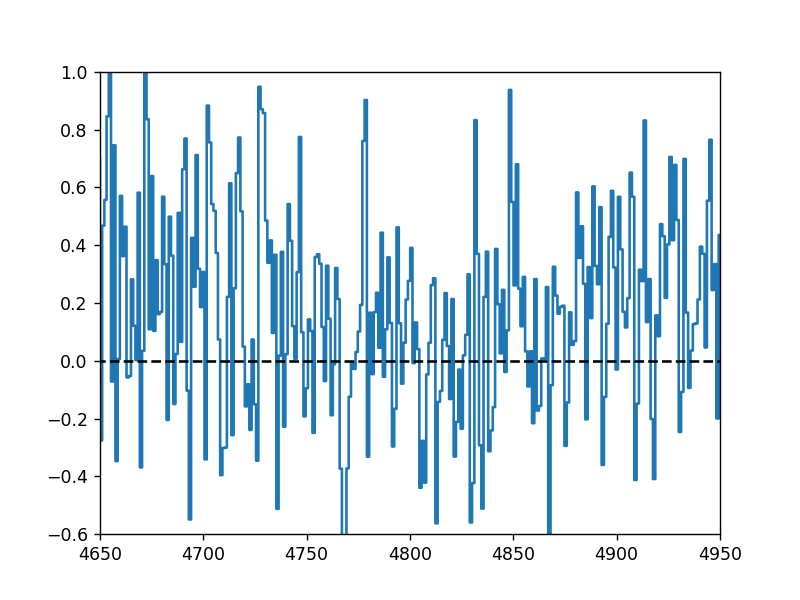

In [20]:
plt.clf()
ax = plt.gca()
ax.plot(spec.wavelength, spec.flux, drawstyle='steps-mid')
ax.plot([4000., 10000.], [0.]*2, 'k--')
ax.set_xlim(4650, 4950)
ax.set_ylim(-0.6, 1.)
plt.show()

#### Histogram

<IPython.core.display.Javascript object>


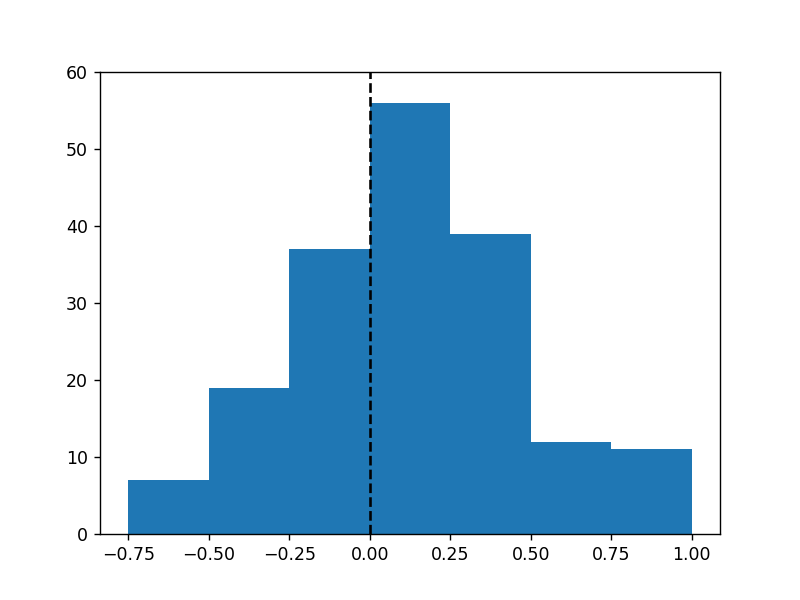

In [33]:
plt.clf()
ax = plt.gca()
pix = (spec.wavelength > 4700.*u.AA) & (spec.wavelength < 4900*u.AA)
ax.hist(spec.flux[pix], bins=[-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75, 1.])
ax.plot([0.]*2, [0., 100], 'k--')
#
ax.set_ylim(0.,60)
plt.show()